#                 Arrhythmia Beat Classification

## Step 0 : Lecture d'un enregistrement d'ECG 

Nous allons utiliser les donnees ecg du MIT que vous pouvez telecharger en suivant le liens : https://physionet.org/physiobank/database/mitdb/ 

                Importation des modules 
 Veuillez a telecharger tous les modules  surtout le premier avec 
                    **pip install wfdb**
                    et aussi le module tqdm
                    **pip install tqdm**

In [1]:
import wfdb as wf
import numpy as np
from matplotlib import pyplot as plt
import os
import h5py
import pandas as pd
from glob import glob
from scipy import signal as ss
from matplotlib import pyplot as plt

    Choisir le fichier a lire et a afficher dans un graphique 

In [2]:
FILE=1               # Il  y'a 48 fichier au total donc choisir entre 0 et 47 comme c'est dans une liste.
CHANNEL=0             # Il y a deux canaux
SAMPLE_START=114000   # Début de l'échantillon dans le fichier
SAMPLE_SIZE=4000      # Nombre de lectures (360 par seconde)

In [3]:
def get_records():
    """ 
    Recupere les chemins des donnees dans le dossier data/mitdb
    """

    if not os.path.isdir('data/mitdb'):
        print("veuillez telecharger les donnees mit dans lien donnees \
              \n Si deja fait les mettre dans un dossier mitdb qui est dans un dossier data")
        return 1 

    # Pour les donnees il ya trois extemsion pour chaque element .dat, .atr, .hea
    # Le module glob  trouve tous les  chemins correspondant au schema 
    #    specifie selon les regles utiliser par le Shell Unix
    paths = glob('data/mitdb/*.atr')

    # Se débarrasser de l'extension
    paths = [path[:-4] for path in paths]
    paths.sort()

    return paths

In [4]:
# Recuperer les donnees disponible en utilisant la fonction get_record().
dbfiles = get_records()
print('Total files: ', len(dbfiles))

# Pick the corresponding file.
datfile = dbfiles[FILE]
print('Loading file:', datfile)

# Read the file.
record = wf.rdsamp(datfile)
annotation = wf.rdann(datfile, 'atr')

# Info about the data.
print('Sampling frequency:', record[1].get('fs'))
print('Data shape:', record[0].shape)
print('Annotations:', len(annotation.num))

Total files:  48
Loading file: data/mitdb/101
Sampling frequency: 360
Data shape: (650000, 2)
Annotations: 1874


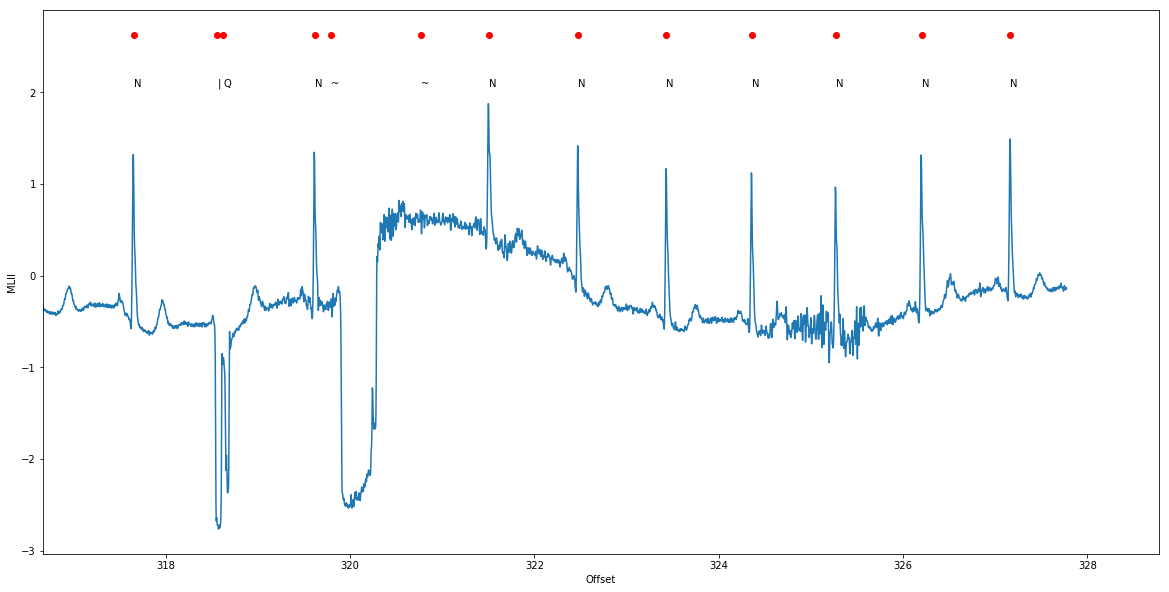

In [5]:
record = wf.rdsamp(datfile)
annotation = wf.rdann(datfile, 'atr')

# Recuperer des données et des annotations pour les échantillons sélectionnés ci-dessous.
sample_end = SAMPLE_START + SAMPLE_SIZE
channel = record[0][SAMPLE_START:sample_end, CHANNEL]

# Tracer du battement du coeur. L'échelle de temps est le nombre de lectures
# divided by sampling frequency.
times = (np.arange(SAMPLE_SIZE, dtype = 'float') + SAMPLE_START) / record[1].get('fs')
plt.figure(figsize=(20,10))
plt.plot(times, channel)

# EXtraire les annotations.
where = np.logical_and(annotation.sample >= SAMPLE_START, annotation.sample < sample_end)
annots = annotation.sample[where] - SAMPLE_START
annotypes = np.array(annotation.symbol)
annotypes = annotypes[where]

# Plot the Annotations.
annotimes = times[annots]
plt.plot(annotimes, np.ones_like(annotimes) * channel.max() * 1.4, 'ro')

# Code des Annotations .
for idx, annot in enumerate(annots):
    plt.annotate(annotypes[idx], xy = (times[annot], channel.max() * 1.1))

plt.xlim([SAMPLE_START / record[1].get('fs'), (sample_end / record[1].get('fs')) + 1])
plt.xlabel('Offset')
plt.ylabel(record[1].get('sig_name')[CHANNEL])
plt.show()

## Step 1 :  Segmentation des battements et la preparation des donnees 

### Convertir ensuite tous les fichiers en fichiers CSV portant le même nom (par exemple, à partir de 100.dat, 100.hea, 100.atr, le fichier 100.csv est généré).

    importation des modules

In [6]:
from scipy import signal
from biosppy.signals import ecg
from subprocess import call 

Au lieu d’utiliser les annotations pour trouver les temps, nous allons utilise la détection de pic R à la place. La raison en est que la même logique peut être utilisée pour analyser de nouvelles donnnes qui ne sont pas encore annotées.
Nous utilisons les annotations ici uniquement pour classer les battments comme normal ou anormal et pour entraîner le modèle.

In [7]:
records = get_records()
print('Total files: ', len(records))

Total files:  48


In [8]:
# Reference:
# https://physionet.org/physiobank/database/html/mitdbdir/intro.htm
realbeats = ['N','L','R','B','A','a','J','S','V','r',
             'F','e','j','n','E','/','f','Q','?']

In [9]:
#creation du dossier devant contenir les fichiers csv cree
dirname = 'data_ecg'
if not os.path.exists(dirname):
    os.makedirs(dirname)

Boucle à travers chaque fichier d'entrée. Chaque fichier contient un
enregistrement des lectures ECG, échantillonné à 360 lectures par seconde.

In [10]:
for path in records:
    pathpts = path.split('/')
    fn = pathpts[-1]
    print('Loading file:', path)

    # Lecture des donnees
    record = wf.rdsamp(path)
    annotation = wf.rdann(path, 'atr')

    # Information sur le signal qu'on extrait
    print('Sampling frequency used for this record:', record[1].get('fs'))
    print('Shape of loaded data array:', record[0].shape)
    print('Number of loaded annotations:', len(annotation.num))
    
    # Recuperer les valeurs de ECG depuis le fichiers
    data = record[0].transpose()

    # Generer la classfication basee dans les annotations.
    # 0.0 = undetermined
    # 1.0 = normal
    # 2.0 = abnormal
    cat = np.array(annotation.symbol)
    rate = np.zeros_like(cat, dtype='float')
    for catid, catval in enumerate(cat):
        if (catval == 'N'):
            rate[catid] = 1.0 # Normal
        elif (catval in realbeats):
            rate[catid] = 2.0 # Abnormal
    rates = np.zeros_like(data[0], dtype='float')
    rates[annotation.sample] = rate
    
    indices = np.arange(data[0].size, dtype='int')

    # Traitez chaque canal séparément (2 par fichier d’entrée).
    for channelid, channel in enumerate(data):
        chname = record[1].get('sig_name')[channelid]
        print('ECG channel type:', chname)
        
        # Trouver les  R_peaks dans les donnees the ECG . La plupart devraient correspondre aux annotations.
        out = ecg.ecg(signal=channel, sampling_rate=360, show=False)
        rpeaks = np.zeros_like(channel, dtype='float')
        rpeaks[out['rpeaks']] = 1.0
        
        beatstoremove = np.array([0])

        # Diviser en battements de coeur individuels.
        # Pour chaque battement de coeur enregistre, ajouter la classification (normal/abnormal).
        beats = np.split(channel, out['rpeaks'])
        for idx, idxval in enumerate(out['rpeaks']):
            firstround = idx == 0
            lastround = idx == len(beats) - 1

            # Passer le premier et le dernier battement.
            if (firstround or lastround):
                continue

            # Obtenir la valeur de classification qui est sur ou près de la position de l'index de réponse.
            fromidx = 0 if idxval < 10 else idxval - 10
            toidx = idxval + 10
            catval = rates[fromidx:toidx].max()
            
            # Ignorer les temps s'il n'y a pas de classement.
            if (catval == 0.0):
                beatstoremove = np.append(beatstoremove, idx)
                continue

            # Le temps normal est maintenant classé comme 0.0 et anormal est 1.0.
            catval = catval - 1.0

            # Ajouter des lectures supplémentaires du prochain temps.
            beats[idx] = np.append(beats[idx], beats[idx+1][:40])

            # Normaliser les lectures sur une plage de 0 à 1 à des fins de ML.
            beats[idx] = (beats[idx] - beats[idx].min()) / beats[idx].ptp()

            # Resample from 360Hz to 125Hz
            newsize = int((beats[idx].size * 125 / 360) + 0.5)
            beats[idx] = signal.resample(beats[idx], newsize)

            # Annuler les enregistrement superieur a 187.
            if (beats[idx].size > 187):
                beatstoremove = np.append(beatstoremove, idx)
                continue

            # Remplir avec des 0 si la tailles est inferieur a 187 .
            zerocount = 187 - beats[idx].size
            beats[idx] = np.pad(beats[idx], (0, zerocount), 'constant', constant_values=(0.0, 0.0))

            # Ajouter la classification dans le battemenet de la donnees.
            beats[idx] = np.append(beats[idx], catval)

        beatstoremove = np.append(beatstoremove, len(beats)-1)

        # Supprimez les premier et dernier battements et ceux sans classification.
        beats = np.delete(beats, beatstoremove)

        # Save to CSV file.            
        os.chdir(dirname)    
        savedata = np.array(list(beats[:]), dtype=np.float)
        outfn = fn+'_'+chname+'.csv'
        #creation du fichier
        call('touch ' + outfn, shell=True)
        print('Generating ', outfn)
        with open(outfn, "wb") as fin:
            np.savetxt(fin, savedata, delimiter=",", fmt='%f')
        os.chdir('..')

Loading file: data/mitdb/100
Sampling frequency used for this record: 360
Shape of loaded data array: (650000, 2)
Number of loaded annotations: 2274
ECG channel type: MLII


/home/kairemor/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/home/kairemor/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/home/kairemor/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be

Generating  100_MLII.csv
ECG channel type: V5
Generating  100_V5.csv
Loading file: data/mitdb/101
Sampling frequency used for this record: 360
Shape of loaded data array: (650000, 2)
Number of loaded annotations: 1874
ECG channel type: MLII
Generating  101_MLII.csv
ECG channel type: V1
Generating  101_V1.csv
Loading file: data/mitdb/102
Sampling frequency used for this record: 360
Shape of loaded data array: (650000, 2)
Number of loaded annotations: 2192
ECG channel type: V5
Generating  102_V5.csv
ECG channel type: V2
Generating  102_V2.csv
Loading file: data/mitdb/103
Sampling frequency used for this record: 360
Shape of loaded data array: (650000, 2)
Number of loaded annotations: 2091
ECG channel type: MLII
Generating  103_MLII.csv
ECG channel type: V2
Generating  103_V2.csv
Loading file: data/mitdb/104
Sampling frequency used for this record: 360
Shape of loaded data array: (650000, 2)
Number of loaded annotations: 2311
ECG channel type: V5
Generating  104_V5.csv
ECG channel type: V

Generating  214_V1.csv
Loading file: data/mitdb/215
Sampling frequency used for this record: 360
Shape of loaded data array: (650000, 2)
Number of loaded annotations: 3400
ECG channel type: MLII
Generating  215_MLII.csv
ECG channel type: V1
Generating  215_V1.csv
Loading file: data/mitdb/217
Sampling frequency used for this record: 360
Shape of loaded data array: (650000, 2)
Number of loaded annotations: 2280
ECG channel type: MLII
Generating  217_MLII.csv
ECG channel type: V1
Generating  217_V1.csv
Loading file: data/mitdb/219
Sampling frequency used for this record: 360
Shape of loaded data array: (650000, 2)
Number of loaded annotations: 2312
ECG channel type: MLII
Generating  219_MLII.csv
ECG channel type: V1
Generating  219_V1.csv
Loading file: data/mitdb/220
Sampling frequency used for this record: 360
Shape of loaded data array: (650000, 2)
Number of loaded annotations: 2069
ECG channel type: MLII
Generating  220_MLII.csv
ECG channel type: V1
Generating  220_V1.csv
Loading file:

###  Affichage d'un enregistrement dernierement creer en fichier csv 

In [11]:
data = np.loadtxt('data_ecg/ML2/232_MLII.csv', delimiter=',')
print(data.shape)
data[0][:-1].shape

(1437, 188)


(187,)

In [12]:
data[:,-1]


array([1., 1., 1., ..., 1., 1., 1.])

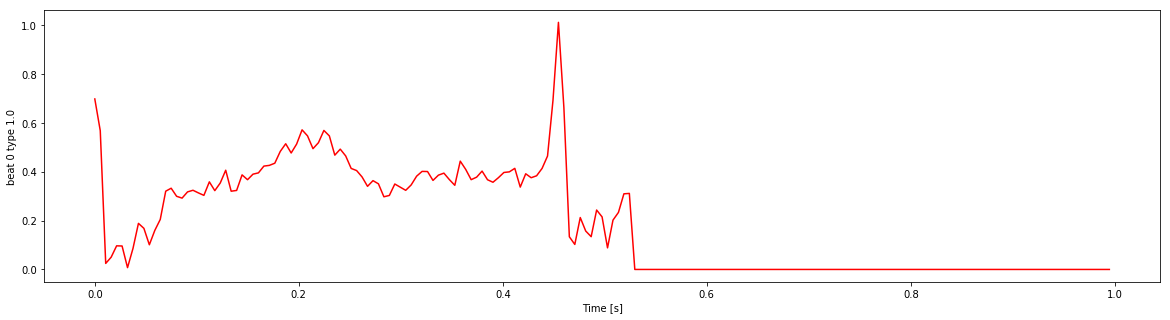

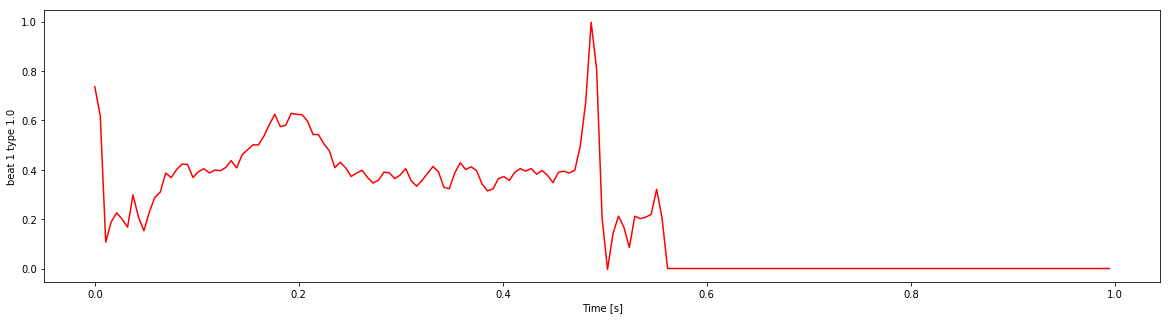

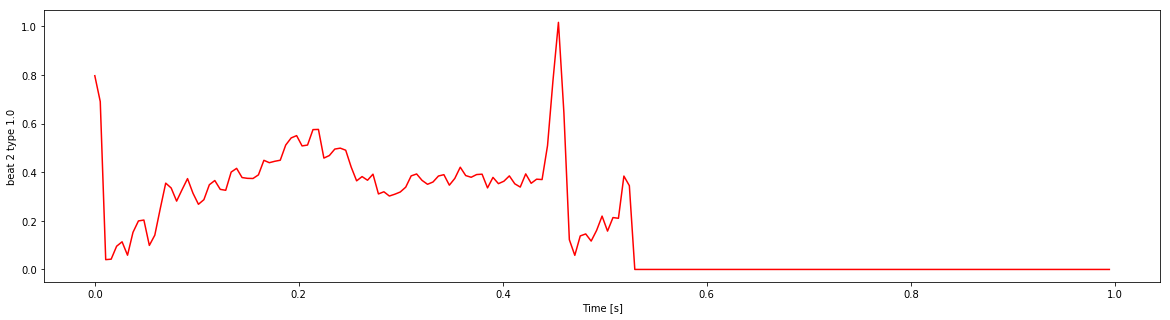

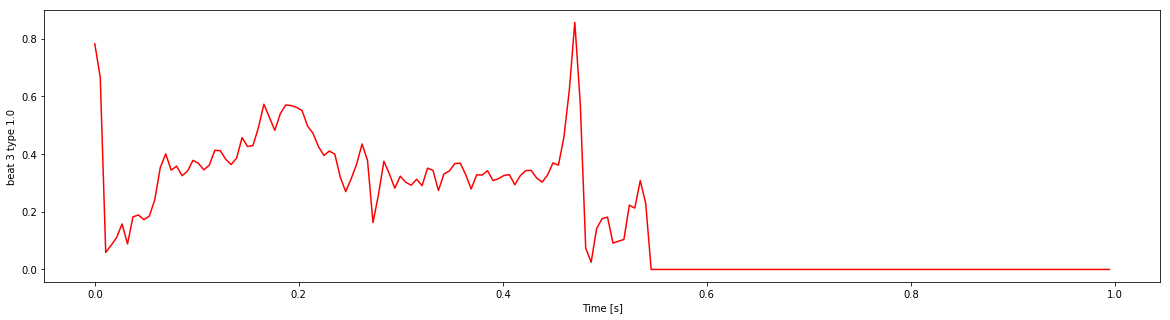

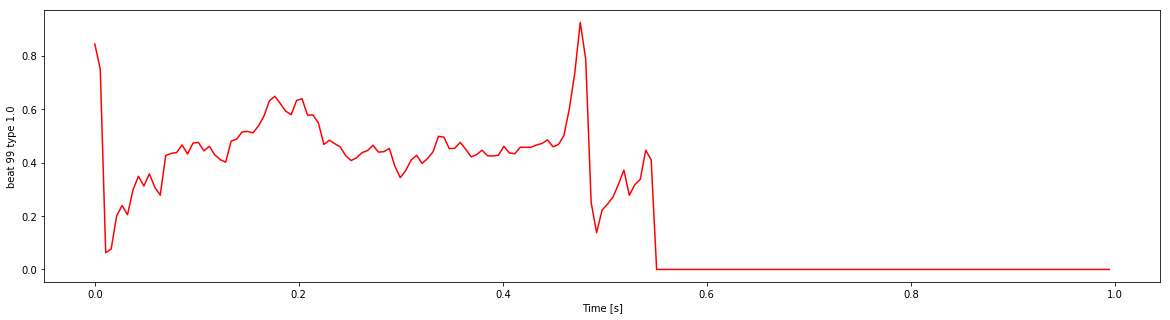

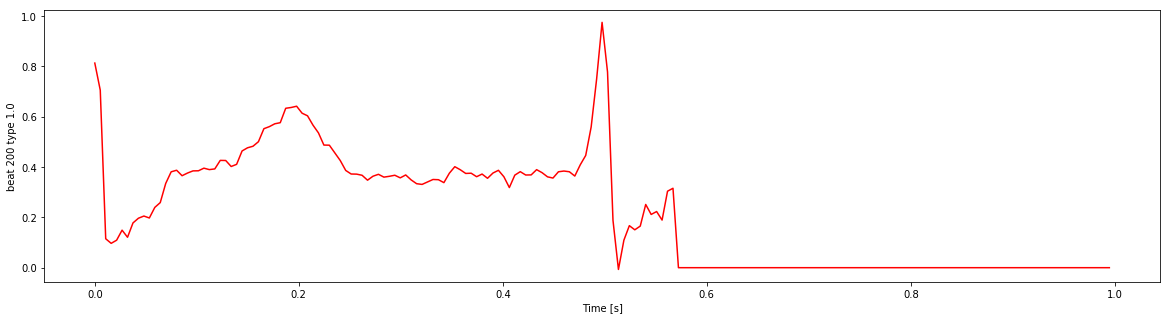

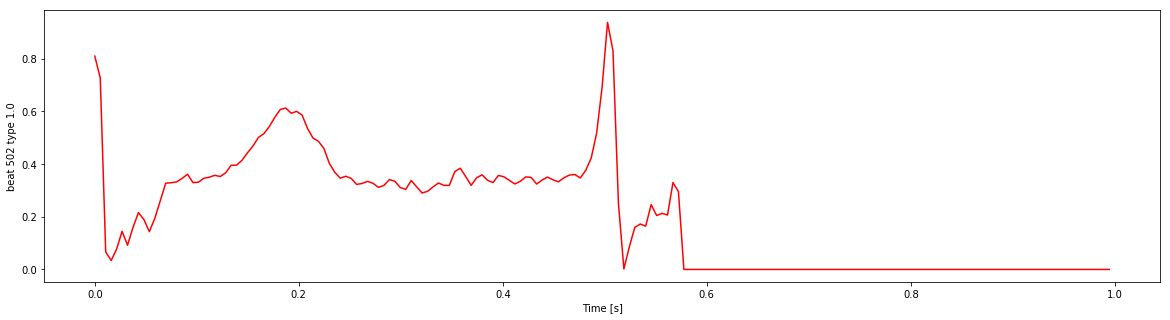

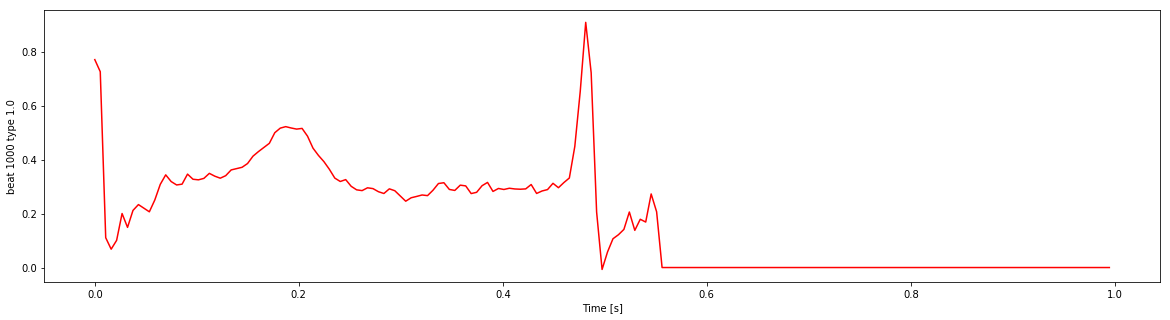

In [13]:
for beatid in [0,1,2,3,99,200,502,1000]:
    times = np.arange(187, dtype = 'float') / 187
    beat = data[beatid][:-1]
    anno = data[beatid][-1]
    plt.figure(figsize=(20,5))
    if (anno == 0.0):
      plt.plot(times, beat, 'b')
    else:
      plt.plot(times, beat, 'r')
    plt.xlabel('Time [s]')
    plt.ylabel('beat ' + str(beatid) + " type " + str(anno))
    plt.show()

### Preparation des donnees csv en les departageant en donnnes d'entrainement, de teste,et de validation

In [14]:
alldata = np.empty(shape=[0, 188])
print(alldata.shape)
paths = glob('data_ecg/ML2/*.csv')
for path in paths:
    print('Loading ', path)
    csvrows = np.loadtxt(path, delimiter=',')
    alldata = np.append(alldata, csvrows, axis=0)

(0, 188)
Loading  data_ecg/ML2/234_MLII.csv
Loading  data_ecg/ML2/220_MLII.csv
Loading  data_ecg/ML2/108_MLII.csv
Loading  data_ecg/ML2/119_MLII.csv
Loading  data_ecg/ML2/223_MLII.csv
Loading  data_ecg/ML2/214_MLII.csv
Loading  data_ecg/ML2/121_MLII.csv
Loading  data_ecg/ML2/117_MLII.csv
Loading  data_ecg/ML2/219_MLII.csv
Loading  data_ecg/ML2/201_MLII.csv
Loading  data_ecg/ML2/228_MLII.csv
Loading  data_ecg/ML2/222_MLII.csv
Loading  data_ecg/ML2/210_MLII.csv
Loading  data_ecg/ML2/118_MLII.csv
Loading  data_ecg/ML2/209_MLII.csv
Loading  data_ecg/ML2/221_MLII.csv
Loading  data_ecg/ML2/230_MLII.csv
Loading  data_ecg/ML2/215_MLII.csv
Loading  data_ecg/ML2/122_MLII.csv
Loading  data_ecg/ML2/103_MLII.csv
Loading  data_ecg/ML2/212_MLII.csv
Loading  data_ecg/ML2/231_MLII.csv
Loading  data_ecg/ML2/113_MLII.csv
Loading  data_ecg/ML2/202_MLII.csv
Loading  data_ecg/ML2/115_MLII.csv
Loading  data_ecg/ML2/205_MLII.csv
Loading  data_ecg/ML2/200_MLII.csv
Loading  data_ecg/ML2/233_MLII.csv
Loading  da

### Separation en enregistrement des donnnees

In [15]:
train_data = np.empty(shape=[0, 188])
test_data = np.empty(shape=[0, 188])
validate_data = np.empty(shape=[0, 188])
i = 0 
paths = glob('data_ecg/ML2/*.csv')
for path in paths:
    if i <= 10:
        print('Loading ',i, path)
        csvrows = np.loadtxt(path, delimiter=',')
        validate_data = np.append(validate_data, csvrows, axis=0)
    elif i >= 11 and i <= 45:
        print('Loading ', i, path)
        csvrows = np.loadtxt(path, delimiter=',')
        train_data = np.append(train_data, csvrows, axis=0)
    else:
        print('Loading ',i, path)
        csvrows = np.loadtxt(path, delimiter=',')
        test_data = np.append(test_data, csvrows, axis=0)
    i = i + 1

Loading  0 data_ecg/ML2/234_MLII.csv
Loading  1 data_ecg/ML2/220_MLII.csv
Loading  2 data_ecg/ML2/108_MLII.csv
Loading  3 data_ecg/ML2/119_MLII.csv
Loading  4 data_ecg/ML2/223_MLII.csv
Loading  5 data_ecg/ML2/214_MLII.csv
Loading  6 data_ecg/ML2/121_MLII.csv
Loading  7 data_ecg/ML2/117_MLII.csv
Loading  8 data_ecg/ML2/219_MLII.csv
Loading  9 data_ecg/ML2/201_MLII.csv
Loading  10 data_ecg/ML2/228_MLII.csv
Loading  11 data_ecg/ML2/222_MLII.csv
Loading  12 data_ecg/ML2/210_MLII.csv
Loading  13 data_ecg/ML2/118_MLII.csv
Loading  14 data_ecg/ML2/209_MLII.csv
Loading  15 data_ecg/ML2/221_MLII.csv
Loading  16 data_ecg/ML2/230_MLII.csv
Loading  17 data_ecg/ML2/215_MLII.csv
Loading  18 data_ecg/ML2/122_MLII.csv
Loading  19 data_ecg/ML2/103_MLII.csv
Loading  20 data_ecg/ML2/212_MLII.csv
Loading  21 data_ecg/ML2/231_MLII.csv
Loading  22 data_ecg/ML2/113_MLII.csv
Loading  23 data_ecg/ML2/202_MLII.csv
Loading  24 data_ecg/ML2/115_MLII.csv
Loading  25 data_ecg/ML2/205_MLII.csv
Loading  26 data_ecg/M

In [16]:
x_train_enr = train_data[:, :-1]
y_train_enr = train_data[:, -1].astype(int)

x_validate_enr = validate_data[:, :-1]
y_validate_enr = validate_data[:, -1].astype(int)

x_test_enr = test_data[:, :-1]
y_test_enr = test_data[:, -1].astype(int)

In [17]:
np.bincount(y_train_enr)

array([53226, 22254])

In [18]:
alldata.shape

(98318, 188)

In [19]:
# melanger les donnees et les separer en donnnes entrainement test et de validation
np.random.shuffle(alldata)
totrows = len(alldata)
trainrows = int((totrows * 3 / 5) + 0.5) # 60%
testrows = int((totrows * 1 / 5) + 0.5) # 20%
validaterows = totrows - trainrows - testrows # 20%
mark1 = trainrows
mark2 = mark1 + testrows

In [20]:
with open('train.csv', "wb") as fin:
    np.savetxt(fin, alldata[:mark1], delimiter=",", fmt='%f')

In [21]:
with open('test.csv', "wb") as fin:
    np.savetxt(fin, alldata[mark1:mark2], delimiter=",", fmt='%f')

In [22]:
with open('validate.csv', "wb") as fin:
    np.savetxt(fin, alldata[mark2:], delimiter=",", fmt='%f')

## Step2 : Lecture et affichages des donnees et la Reduction des dimensions par ACP

In [23]:
# Training dataset.
df = pd.read_csv("train.csv", header=None)
x_train = df.values[:, :-1]
y_train = df.values[:, -1].astype(int)

# Validation dataset.
df = pd.read_csv("validate.csv", header=None)
x_validate = df.values[:, :-1]
y_validate = df.values[:, -1].astype(int)

# Test dataset.
df = pd.read_csv("test.csv", header=None)
x_test = df.values[:, :-1]
y_test = df.values[:, -1].astype(int)

In [24]:
np.bincount(y_train)

array([43317, 15674])

In [25]:
np.bincount(y_train_enr)

array([53226, 22254])

In [26]:
C0 = np.argwhere(y_train == 0).flatten()
C1 = np.argwhere(y_train == 1).flatten()

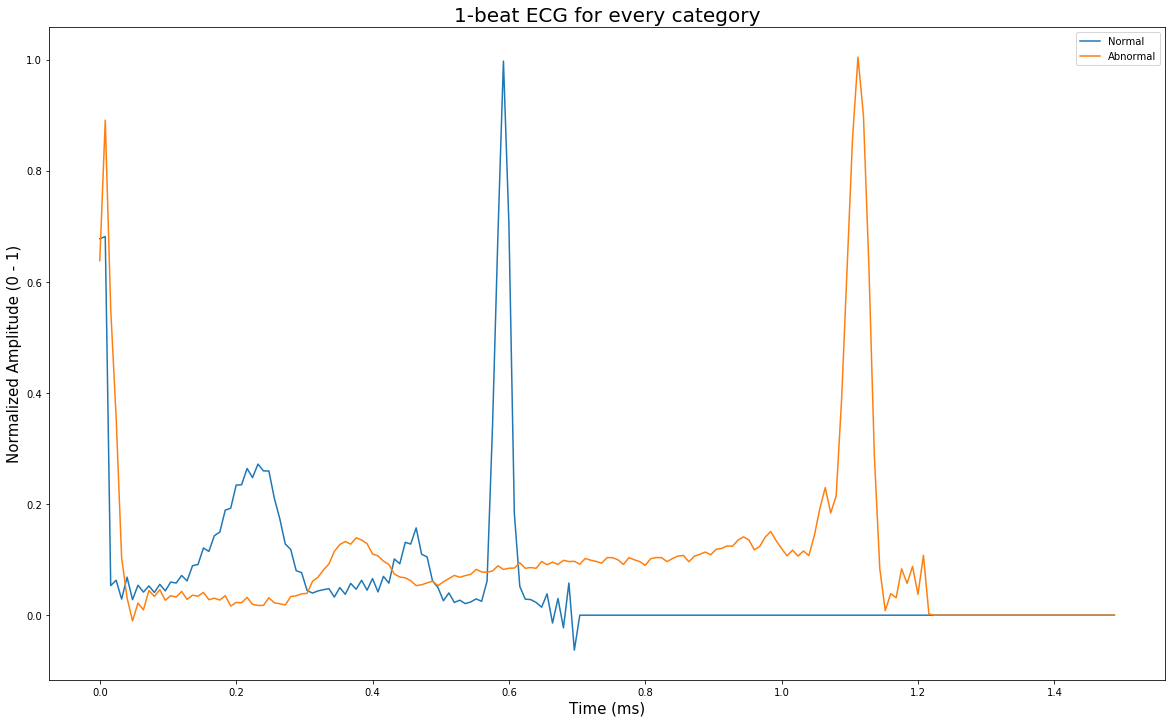

In [27]:
x = np.arange(0, 187)*8/1000.0

plt.figure(figsize=(20,12))
plt.plot(x, x_train[C0, :][0], label="Normal") # Display first normal beat.
plt.plot(x, x_train[C1, :][0], label="Abnormal") # Display first abnormal beat.
plt.legend()
plt.title("1-beat ECG for every category", fontsize=20)
plt.ylabel("Normalized Amplitude (0 - 1)", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

In [28]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , recall_score , f1_score
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

[]

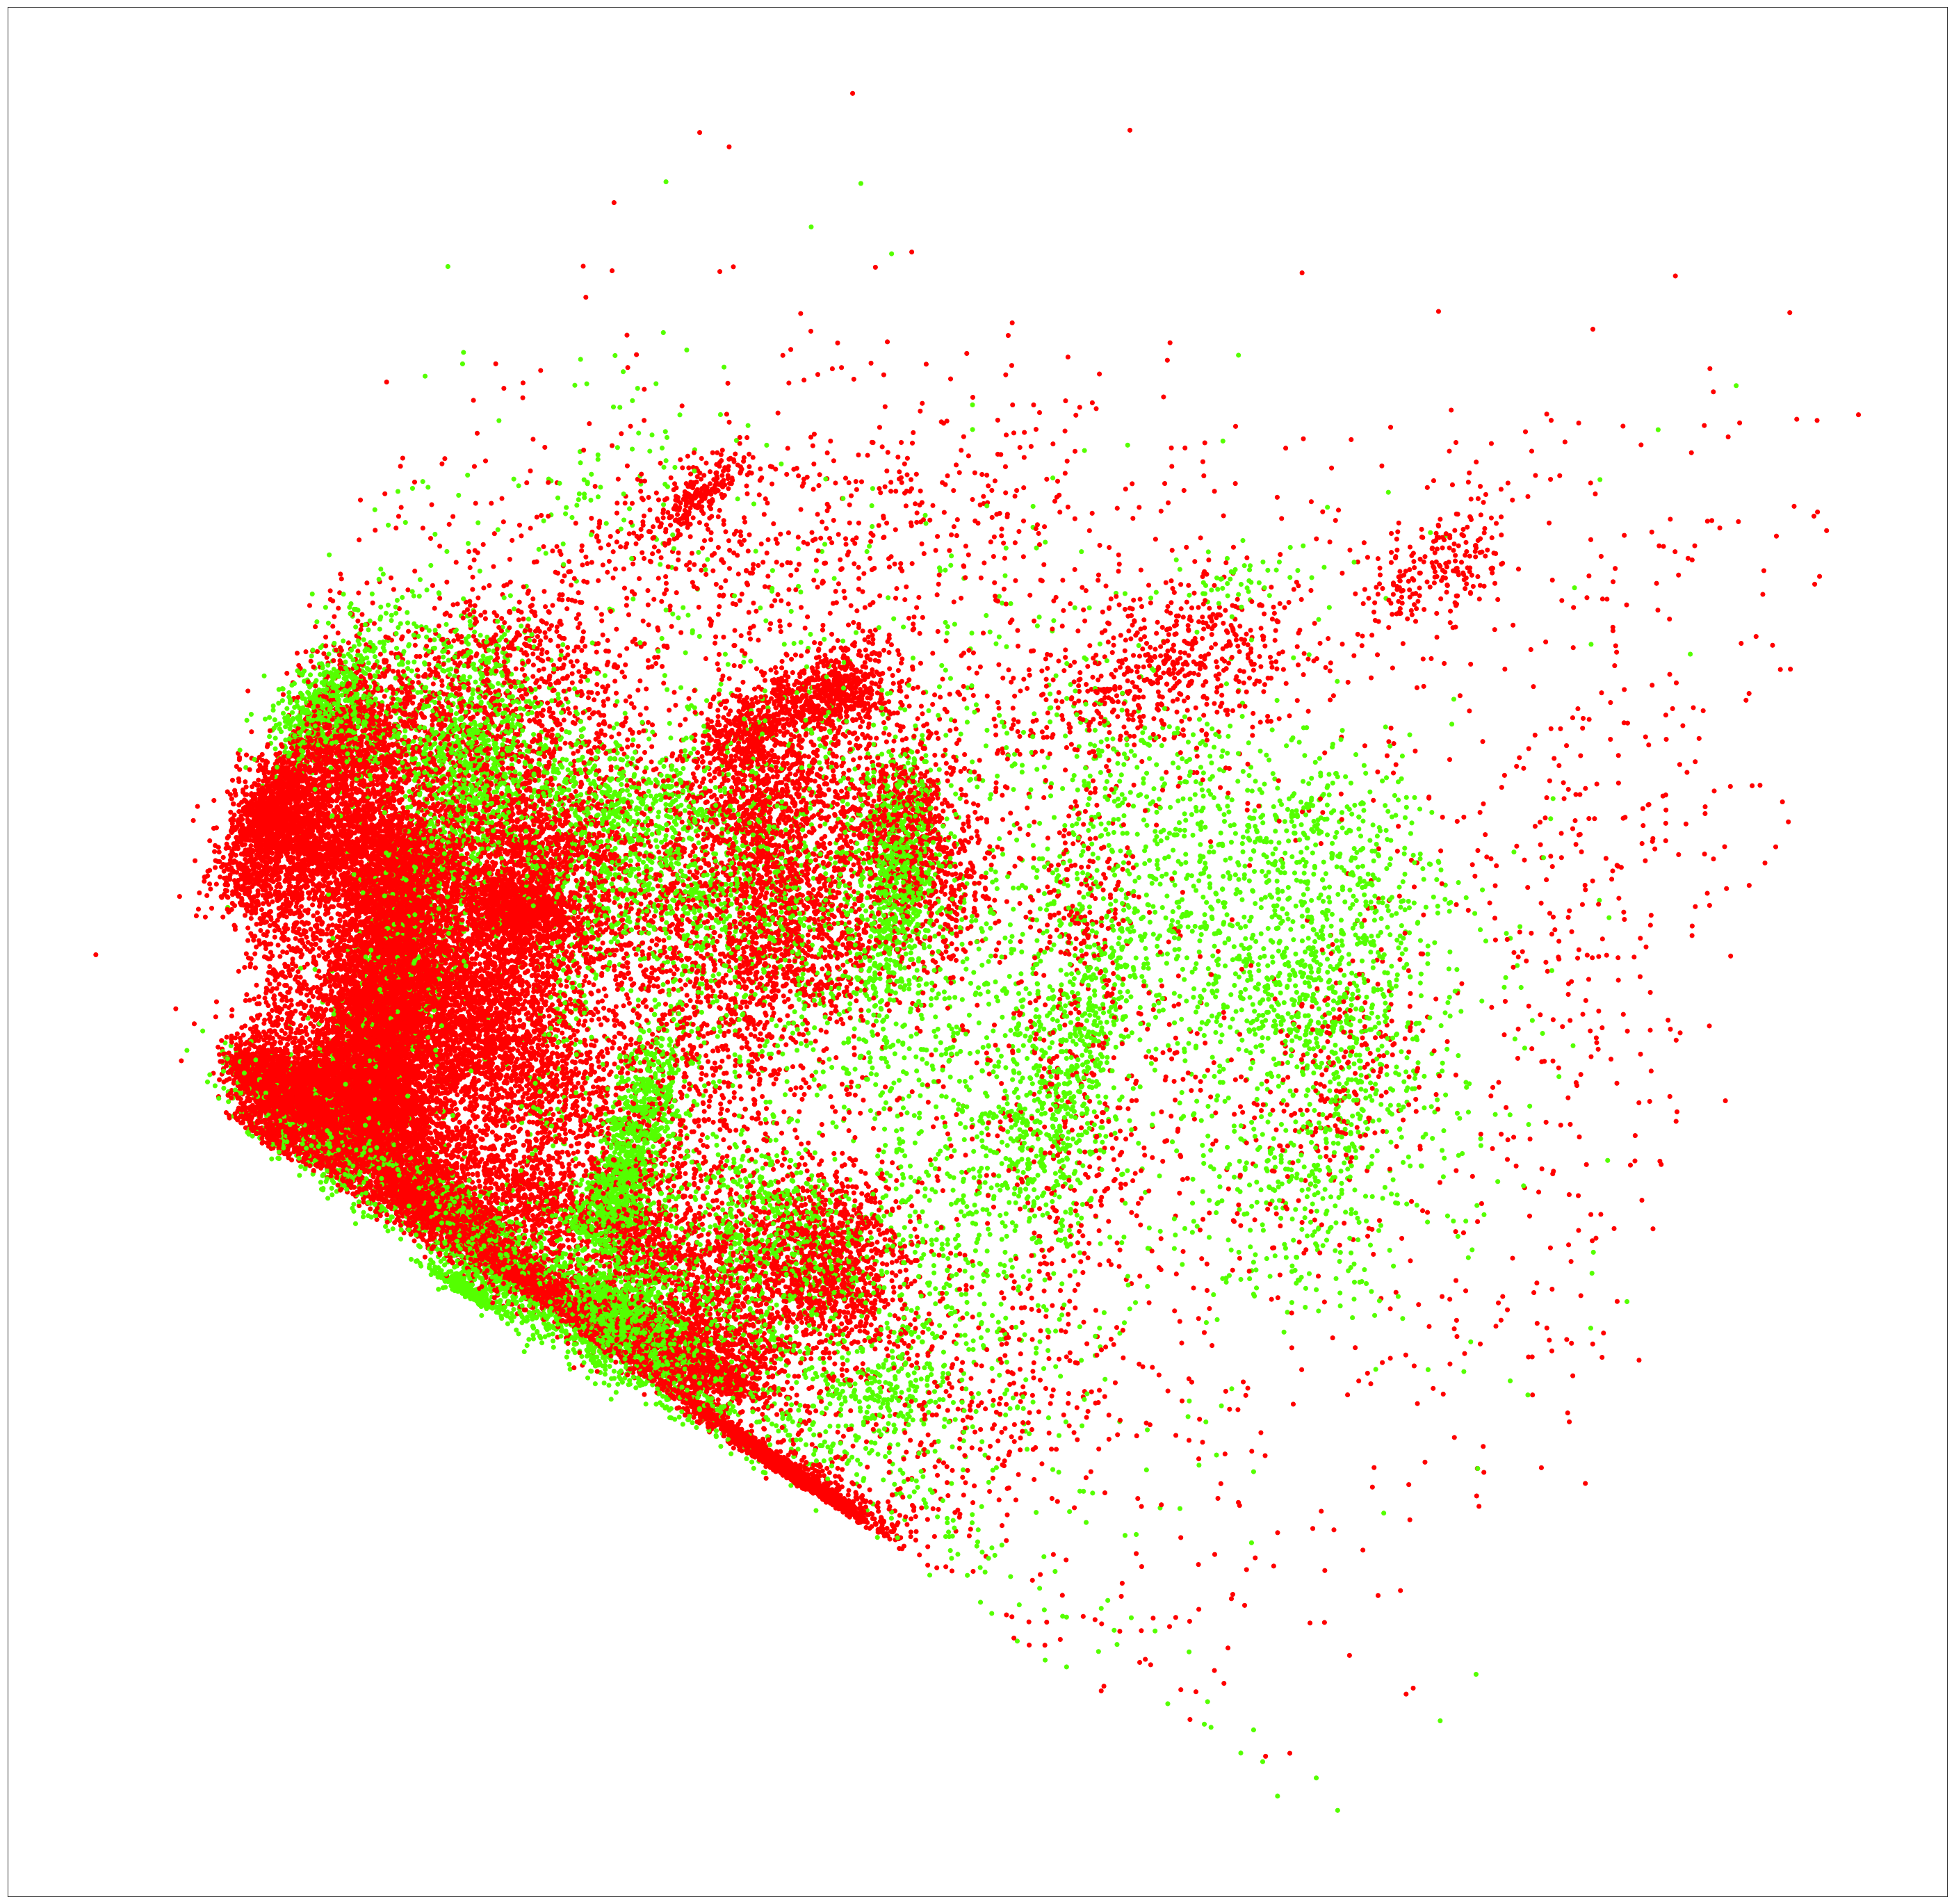

In [29]:
pca = PCA(n_components=2)
fig, plot = plt.subplots()
fig.set_size_inches(50, 50)
plt.prism()
X_transformed = pca.fit_transform(x_train)
plot.scatter(X_transformed[:, 0], X_transformed[:, 1],c=y_train)
plot.set_xticks(())
plot.set_yticks(())

## Step 3-1 : Entrainement avec les donnees melanger de notre modele de Random forest

In [30]:
clt = RandomForestClassifier(n_estimators=100, n_jobs=10, random_state=0)

In [31]:
st = time.time()
clt.fit(x_train, y_train)
time_taken = time.time() - st 

In [32]:
print("Le temps mis pour entrainer notre Random Forest  : ", time_taken)

Le temps mis pour entrainer notre Random Forest  :  28.32586407661438


###  Validation du modele

In [33]:
pre_rnd = clt.predict(x_validate)

In [34]:
x_validate.shape

(19663, 187)

In [35]:
pre_rnd.shape

(19663,)

In [36]:
pd.crosstab(y_validate, pre_rnd, rownames=['vrai'], colnames=['predi'])

predi,0,1
vrai,,
0,14213,81
1,305,5064


In [37]:
confusion_matrix(y_validate, pre_rnd)

array([[14213,    81],
       [  305,  5064]])

In [38]:
accuracy_score(y_validate, pre_rnd)

0.9803692213802573

In [39]:
recall_score(y_validate, pre_rnd)

0.9431924008195195

In [40]:
f1_score(y_validate, pre_rnd)

0.9632870458436371

In [95]:
res_name = ['Precision', 'Rappel', 'F1_score']

In [86]:
acc_rnd = 100*accuracy_score(y_validate, pre_rnd)
rec_rnd = 100*recall_score(y_validate, pre_rnd)
f1_rnd = 100*f1_score(y_validate, pre_rnd)

In [88]:
result_rnd = [acc_rnd.astype(int), rec_rnd.astype(int), f1_rnd.astype(int)]

In [89]:
result_rnd

[98, 94, 96]

### Test du modele 

In [41]:
prediction = clt.predict(x_test)

In [42]:
clt.score(x_test, y_test)

0.9800650935720098

In [43]:
y_record_test = clt.predict(x_test_enr) 

In [44]:
np.bincount(y_record_test)

array([1859,    3])

In [45]:
np.bincount(y_test_enr)

array([1858,    4])

## Step 3-2 : Entrainement avec les donnes separees par enregistrement

In [46]:
clt_enr = RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=0)

In [47]:
len([i for i in y_train_enr if i == 1])
len(y_train_enr)

75480

In [48]:
np.bincount(y_train_enr)

array([53226, 22254])

In [49]:
st = time.time()
clt_enr.fit(x_train_enr, y_train_enr)
time_taken = time.time() - st 

In [50]:
print("Le temps mis est  :" , time_taken)

Le temps mis est  : 79.16799712181091


###  Validation de notre modele 

In [51]:
np.bincount(y_validate_enr)

array([17094,  3882])

In [52]:
y_pre_enr = clt_enr.predict(x_validate_enr)

In [53]:
pd.crosstab(y_validate_enr, y_pre_enr, rownames=['vrai'], colnames=['predi'])

predi,0,1
vrai,,
0,16129,965
1,2683,1199


In [54]:
accuracy_score(y_validate_enr, y_pre_enr)

0.8260869565217391

In [55]:
recall_score(y_validate_enr, y_pre_enr)

0.30886141164348274

In [56]:
f1_score(y_validate_enr, y_pre_enr)

0.39662586834270597

In [57]:
np.bincount(y_test_enr)

array([1858,    4])

In [58]:
test_y = clt_enr.predict(x_test_enr)

In [59]:
np.bincount(test_y)

array([1856,    6])

## Step 4 : Entrainement et Validation de notre modele de SVM par K-Flold Cross-Validato

In [60]:
x_train_svm = x_train[:6000]
y_train_svm = y_train[:6000]

In [61]:
svm_model = SVC(kernel="poly", C=float("inf"), gamma='auto')

In [62]:
svm_model.fit(x_train_svm, y_train_svm)

SVC(C=inf, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [63]:
start = time.time()
score = cross_val_score(svm_model, x_train_svm, y_train_svm, cv=10)
taken_time = time.time() - start

In [64]:
print("Le temps mis pour validation avec la cross validation : %s " %taken_time)

Le temps mis pour validation avec la cross validation : 23.147450923919678 


In [65]:
score

array([0.93677205, 0.94009983, 0.95673877, 0.95341098, 0.96666667,
       0.93666667, 0.94657763, 0.95158598, 0.94991653, 0.95826377])

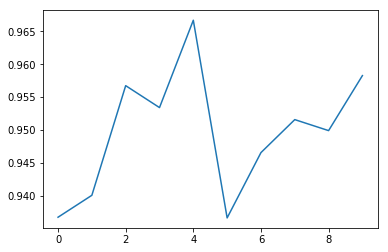

In [66]:
import matplotlib.pyplot as plt 
plt.plot(range(len(score)) ,score)

In [67]:
print("La  moyenne des scores par la validation croise est : %s "  %score.mean())

La  moyenne des scores par la validation croise est : 0.9496698870459825 


In [68]:
pred = svm_model.predict(x_validate)

In [69]:
f1_score(y_validate, pred)

0.9181784524250278

In [70]:
accuracy_score(y_validate,pred)

0.9550424655444235

In [71]:
recall_score(y_validate,pred)

0.9238219407710934

In [90]:
acc_svm = 100*accuracy_score(y_validate, pred)
rec_svm = 100*recall_score(y_validate, pred)
f1_svm = 100*f1_score(y_validate, pred)

In [91]:
result_svm = [acc_svm.astype(int), rec_svm.astype(int), f1_svm.astype(int)]

## Test du model 

In [72]:
predictions = svm_model.predict(x_test)

In [73]:
svm_model.score(x_test, y_test)

0.9556041497152156

In [74]:
test_record = svm_model.predict(x_test_enr)

In [75]:
np.bincount(test_record)

array([1851,   11])

In [76]:
np.bincount(y_test_enr)

array([1858,    4])

## Comparaison

In [99]:
res_name


['Precision', 'Rappel', 'F1_score']

In [98]:
result_rnd

[98, 94, 96]

In [94]:
result_svm

[95, 92, 91]